In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/covid19-global-forecasting-week-3/train.csv
/kaggle/input/covid19-global-forecasting-week-3/submission.csv
/kaggle/input/covid19-global-forecasting-week-3/test.csv


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [11]:
train=pd.read_csv('/kaggle/input/covid19-global-forecasting-week-3/train.csv')
test=pd.read_csv('/kaggle/input/covid19-global-forecasting-week-3/test.csv')
all_data=pd.concat([train,test],axis=0)
all_data.reset_index(drop=True)

,ConfirmedCases,Country_Region,Date,Fatalities,ForecastId,Id,Province_State
0,0.0,Afghanistan,2020-01-22,0.0,NaN,1.0,NaN
1,0.0,Afghanistan,2020-01-23,0.0,NaN,2.0,NaN
2,0.0,Afghanistan,2020-01-24,0.0,NaN,3.0,NaN
3,0.0,Afghanistan,2020-01-25,0.0,NaN,4.0,NaN
4,0.0,Afghanistan,2020-01-26,0.0,NaN,5.0,NaN
...,...,...,...,...,...,...,...
36715,NaN,Zimbabwe,2020-05-03,NaN,13154.0,NaN,NaN
36716,NaN,Zimbabwe,2020-05-04,NaN,13155.0,NaN,NaN
36717,NaN,Zimbabwe,2020-05-05,NaN,13156.0,NaN,NaN
36718,NaN,Zimbabwe,2020-05-06,NaN,13157.0,NaN,NaN


In [12]:
train.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [13]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23562 entries, 0 to 23561
Data columns (total 6 columns):
Id                23562 non-null int64
Province_State    10010 non-null object
Country_Region    23562 non-null object
Date              23562 non-null object
ConfirmedCases    23562 non-null float64
Fatalities        23562 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.1+ MB


In [14]:
train['Country_Region'].nunique()

180

So, according to this dataset, we are analyzing 173 countries which are affected by Corona.

In [15]:
train[train['Province_State'].isna()==False]['Country_Region'].nunique()

8

In [16]:
train.drop(columns='Province_State', inplace=True)

In [17]:
all_data.drop(columns='Province_State',inplace=True)

In [18]:
# Resetting Date column into Datetime object and making it an index of dataframe
train['Date']=pd.to_datetime(train['Date'])
train.set_index('Date',inplace=True)

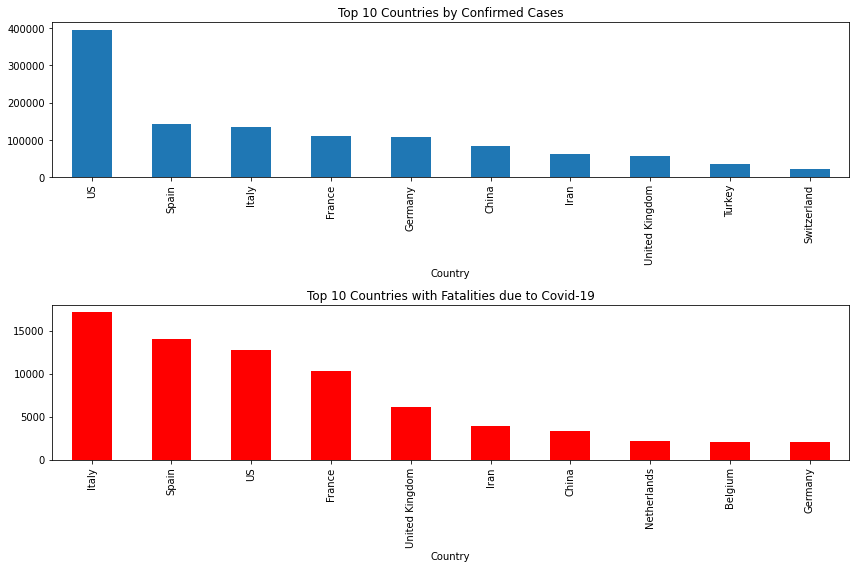

In [19]:
pivot=pd.pivot_table(train,columns='Country_Region',index='Date',values='ConfirmedCases',aggfunc=np.sum)
pivot_fatality=pd.pivot_table(train,columns='Country_Region',index='Date',values='Fatalities',aggfunc=np.sum)
country_list=[]
value_list=[]
fatality_list=[]
for country in list(pivot.columns):
    country_list.append(country)
    value_list.append(pivot[country].max())
    fatality_list.append(pivot_fatality[country].max())
    new_dict={'Country':country_list,'Confirmed':value_list,'Fatality':fatality_list}
df=pd.DataFrame.from_dict(new_dict)
df.set_index('Country',inplace=True)

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
df['Confirmed'].sort_values(ascending=False)[:10].plot(kind='bar')
plt.title('Top 10 Countries by Confirmed Cases')
plt.subplot(2,1,2)
df['Fatality'].sort_values(ascending=False)[:10].plot(kind='bar',color='red')
plt.title('Top 10 Countries with Fatalities due to Covid-19')
plt.tight_layout()

In [20]:
top_confirmed=df.sort_values(by='Confirmed',ascending=False)[:10]

In [21]:
# Make List of Top 10 Countries and India and Netherlands- The Countries of interest.
list_countries=list(top_confirmed.index)
list_countries.append('India')
list_countries.append('Netherlands')

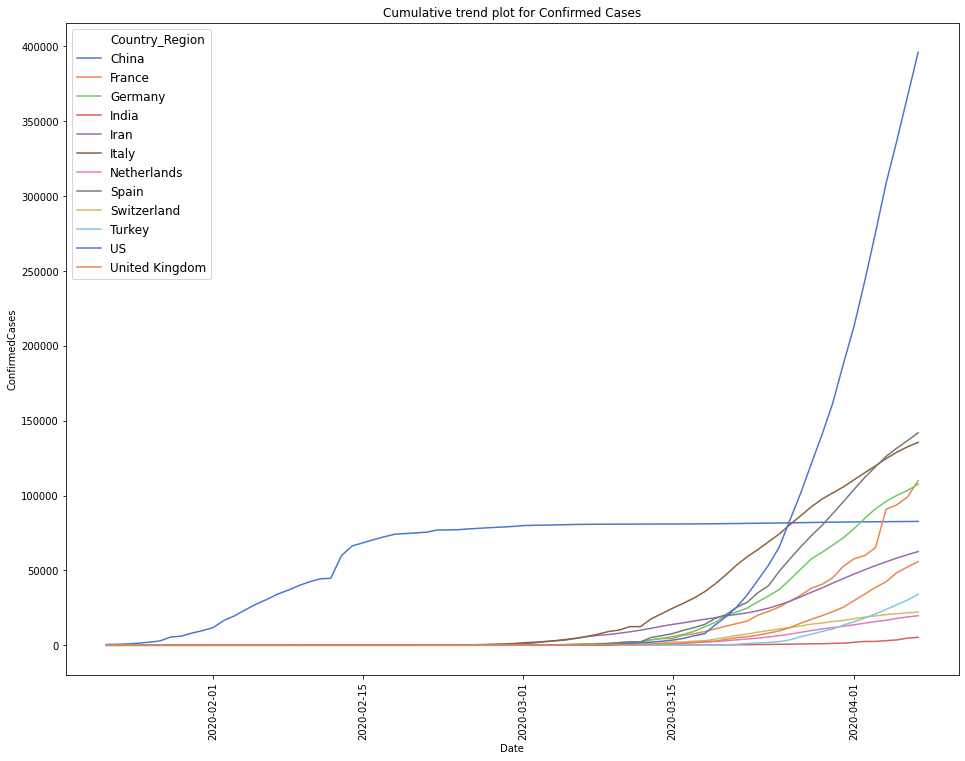

In [22]:
times_series_cntr = train.groupby(['Date','Country_Region'])['ConfirmedCases'].sum()\
                    .reset_index().set_index('Date')
df_countries_tm = times_series_cntr[times_series_cntr['Country_Region'].isin(list_countries)]


plt.figure(figsize=(16,12))
ax = sns.lineplot(x=df_countries_tm.index, y="ConfirmedCases", hue="Country_Region", data=df_countries_tm,palette='muted').set_title('Cumulative line')
plt.legend(loc=2, prop={'size': 12})
plt.title('Cumulative trend plot for Confirmed Cases')
plt.xticks(rotation=90);

In [23]:
Confirm_pivot=pd.pivot_table(train,index='Date',columns='Country_Region',
                             values='ConfirmedCases',aggfunc=np.sum)

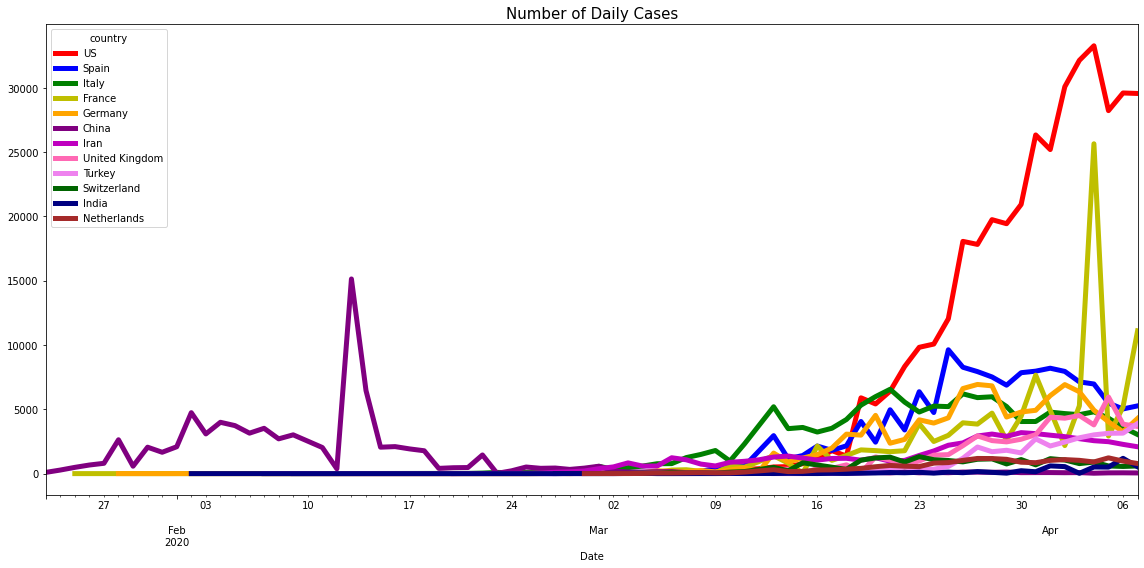

In [24]:
plt.figure(figsize=(16,8))
colors=['r','b','g','y','orange','purple','m','hotpink','violet','darkgreen','navy','brown']
for i,country in enumerate(list_countries):
    Confirm=Confirm_pivot[Confirm_pivot[country]>0][country].diff().fillna(0)
    Confirm=Confirm[Confirm>0]
    Confirm.plot(color=colors[i],label=country,markersize=12,lw=5)    
    plt.title('Number of Daily Cases',fontsize=15)
    plt.legend(title='country')
plt.tight_layout()

In [25]:
for country in list_countries:
    id_max=Confirm_pivot[country].diff().fillna(0).idxmax()
    maxim=Confirm_pivot[country].diff().fillna(0).max()
    print('Maximum New Cases registered for {0} was {1} on {2}'.format(country,maxim,id_max))

Maximum New Cases registered for US was 33264.0 on 2020-04-04 00:00:00
Maximum New Cases registered for Spain was 9630.0 on 2020-03-25 00:00:00
Maximum New Cases registered for Italy was 6557.0 on 2020-03-21 00:00:00
Maximum New Cases registered for France was 25646.0 on 2020-04-04 00:00:00
Maximum New Cases registered for Germany was 6933.0 on 2020-03-27 00:00:00
Maximum New Cases registered for China was 15136.0 on 2020-02-13 00:00:00
Maximum New Cases registered for Iran was 3186.0 on 2020-03-30 00:00:00
Maximum New Cases registered for United Kingdom was 5958.0 on 2020-04-05 00:00:00
Maximum New Cases registered for Turkey was 3892.0 on 2020-04-07 00:00:00
Maximum New Cases registered for Switzerland was 1321.0 on 2020-03-23 00:00:00
Maximum New Cases registered for India was 1190.0 on 2020-04-06 00:00:00
Maximum New Cases registered for Netherlands was 1226.0 on 2020-04-05 00:00:00


In [26]:
Fatal_pivot=pd.pivot_table(train,index='Date',columns='Country_Region',values='Fatalities',aggfunc=np.sum)

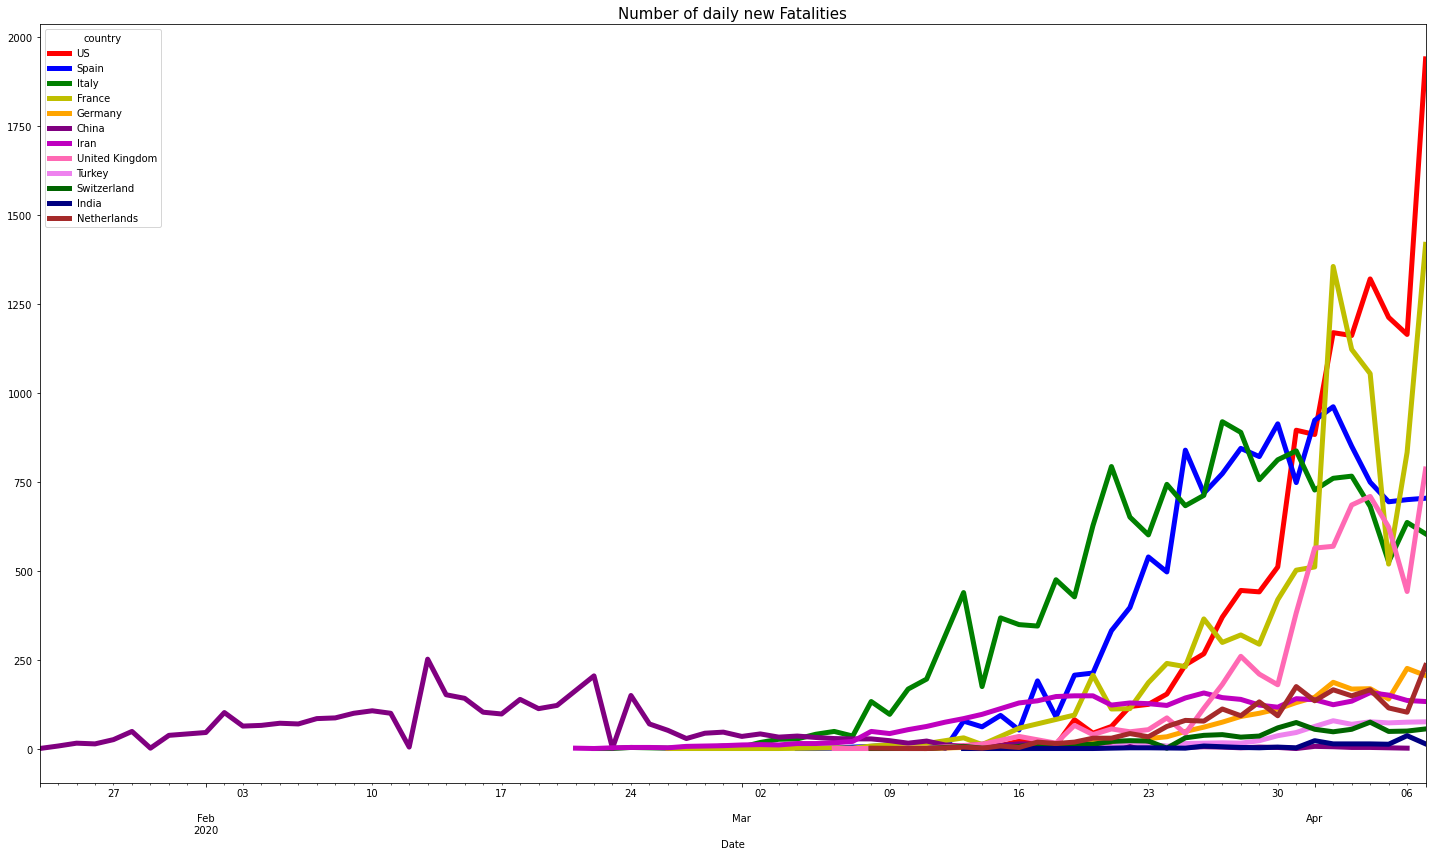

In [27]:
plt.figure(figsize=(20,12))
for i,country in enumerate(list_countries):
    Fatal_diff=Fatal_pivot[(Fatal_pivot[country]>0)][country].diff().fillna(0)
    Fatal_diff=Fatal_diff[Fatal_diff>0]
    Fatal_diff.plot(color=colors[i],label=country,lw=5)
    plt.title('Number of daily new Fatalities',fontsize=15)
    plt.legend(title='country')
plt.tight_layout()

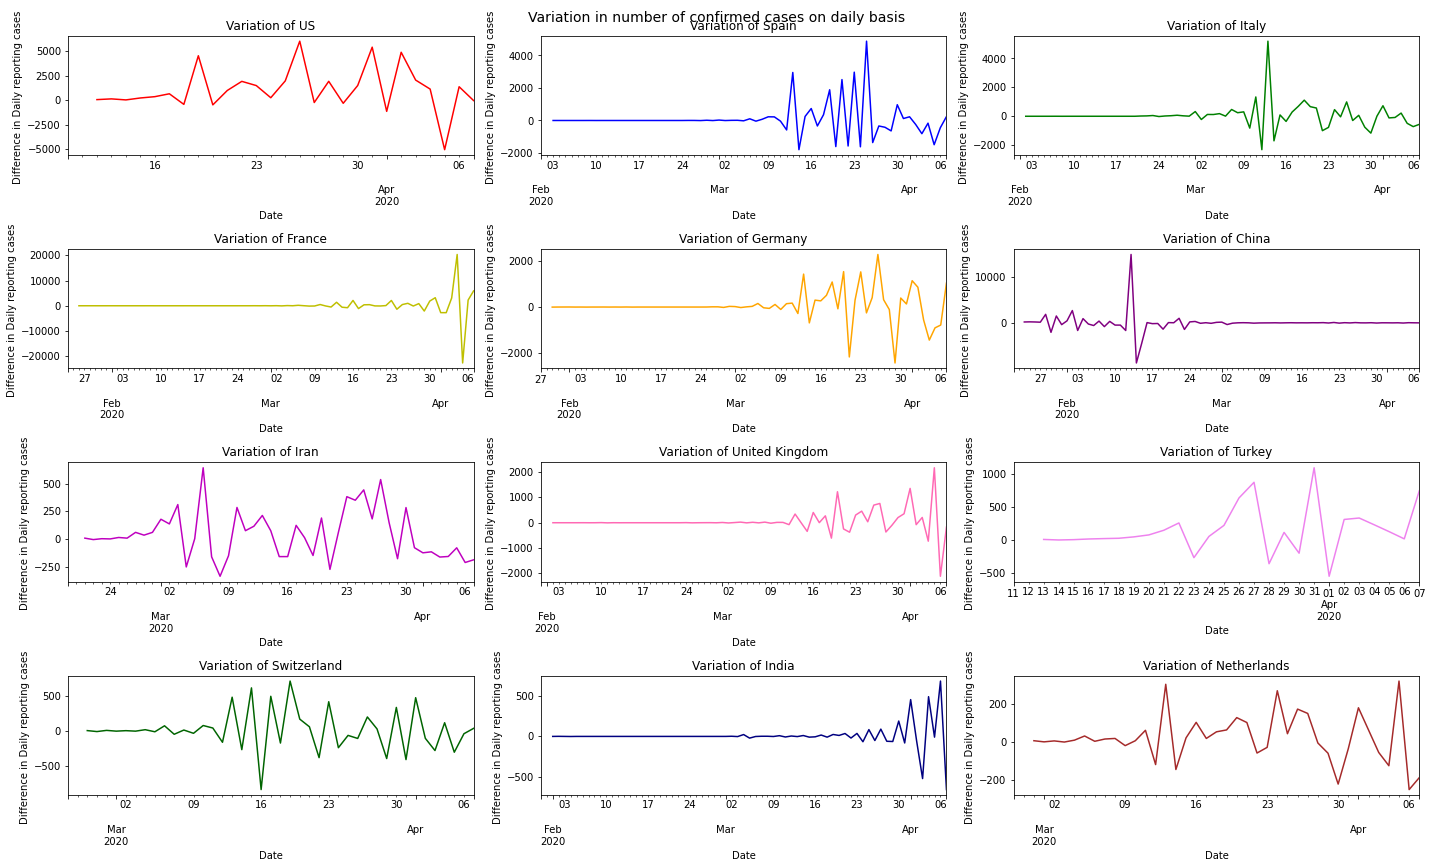

In [28]:
# Understanding New cases confirmation variations on daily basis
plt.figure(figsize=(20,12))
for i,country in enumerate(list_countries):
    plt.subplot(4,3,i+1)
    train[(train['Country_Region']==country)&(train['ConfirmedCases']!=0)].groupby('Date')['ConfirmedCases'].sum().diff().diff().plot(color=colors[i])
    plt.ylabel('Difference in Daily reporting cases ')
    plt.title('Variation of {}'.format(country))
plt.suptitle('Variation in number of confirmed cases on daily basis',fontsize=14,va='bottom')
plt.tight_layout()

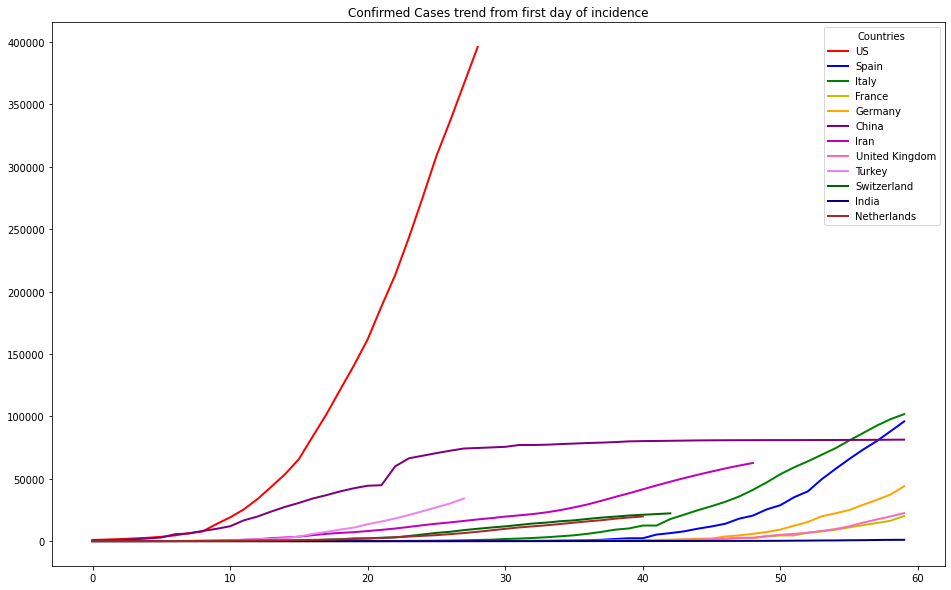

In [30]:
plt.figure(figsize=(16,10))
plt.title('Confirmed Cases trend from first day of incidence')
for i,country in enumerate(list_countries):
    confirm_group=train[(train['Country_Region']==country)&train['ConfirmedCases']!=0].groupby('Date').agg({'ConfirmedCases':['sum']})
    confirm_value=[j for j in confirm_group.ConfirmedCases['sum'].values]
    plot_value=confirm_value[0:60]
    plt.plot(plot_value,color=colors[i],label=country,lw=2)
    plt.legend(title='Countries')

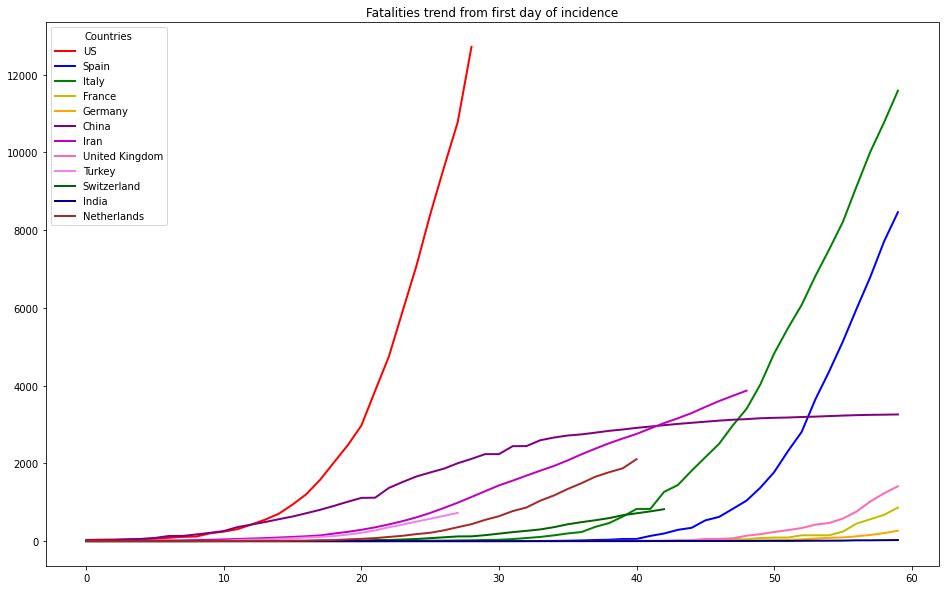

In [31]:
plt.figure(figsize=(16,10))
plt.title('Fatalities trend from first day of incidence')
for i,country in enumerate(list_countries):
    fatal_group=train[(train['Country_Region']==country)&train['ConfirmedCases']!=0].groupby('Date').agg({'Fatalities':['sum']})
    fatal_value=[j for j in fatal_group.Fatalities['sum'].values]
    plot_value=fatal_value[0:60]
    plt.plot(plot_value,color=colors[i],label=country,lw=2)
    plt.legend(title='Countries')

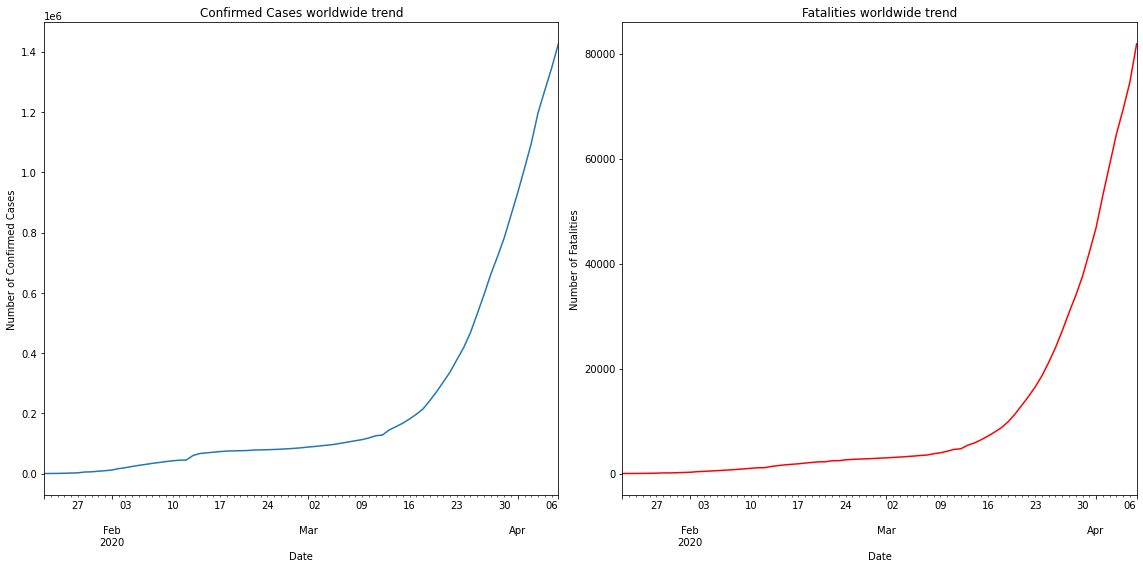

In [32]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
train.groupby('Date')['ConfirmedCases'].sum().plot()
plt.ylabel('Number of Confirmed Cases')
plt.title('Confirmed Cases worldwide trend')

plt.subplot(1,2,2)
train.groupby('Date')['Fatalities'].sum().plot(color='r')
plt.ylabel('Number of Fatalities')
plt.title("Fatalities worldwide trend")

plt.tight_layout()

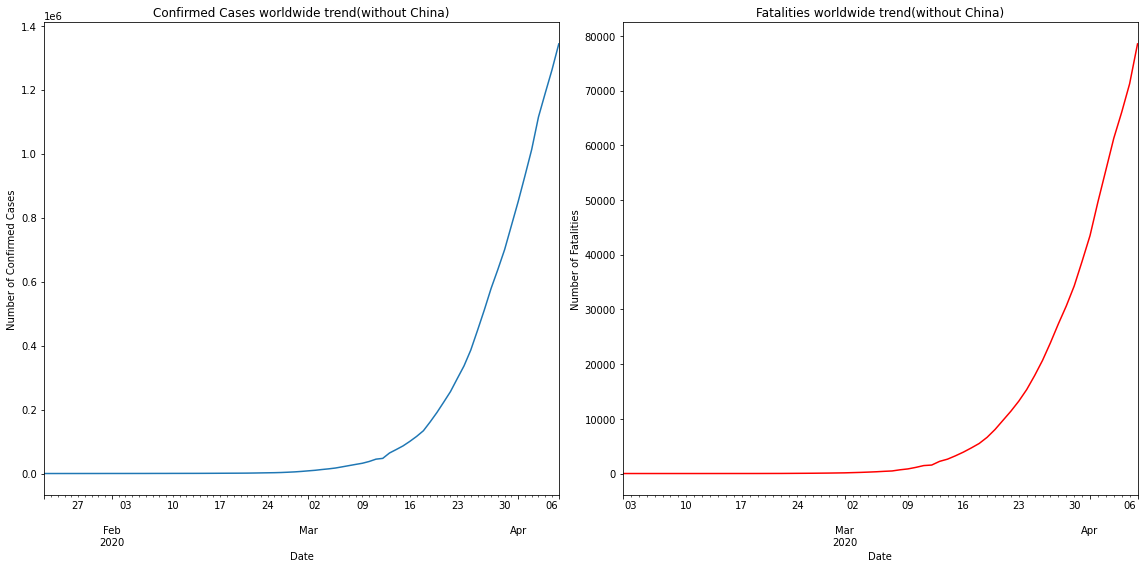

In [33]:
# Confirmed Cases and Fatalities without China's data
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
train[(train['Country_Region']!='China')&(train['ConfirmedCases']!=0)].groupby('Date')['ConfirmedCases'].sum().plot()
plt.ylabel('Number of Confirmed Cases')
plt.title('Confirmed Cases worldwide trend(without China)')

plt.subplot(1,2,2)
train[(train['Country_Region']!='China')&(train['Fatalities']!=0)].groupby('Date')['Fatalities'].sum().plot(color='red')
plt.ylabel('Number of Fatalities')
plt.title("Fatalities worldwide trend(without China)")
plt.tight_layout()
